In [14]:
import logit
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

import importlib
importlib.reload(logit)


metrics = logit.load_DB()


loaded previous DB!!


[0.831360946745562, 0.8451676528599605, 0.8589743589743589, 0.8441814595660749, 0.844921104536489]
[0.786654638824669, 0.8139269133613861, 0.8104983680863695, 0.733330645380171, 0.7861026414131489]
[0.8206586337998127, 0.8367926537582238, 0.8532457847901334, 0.8355783963231159, 0.8365688671678214]


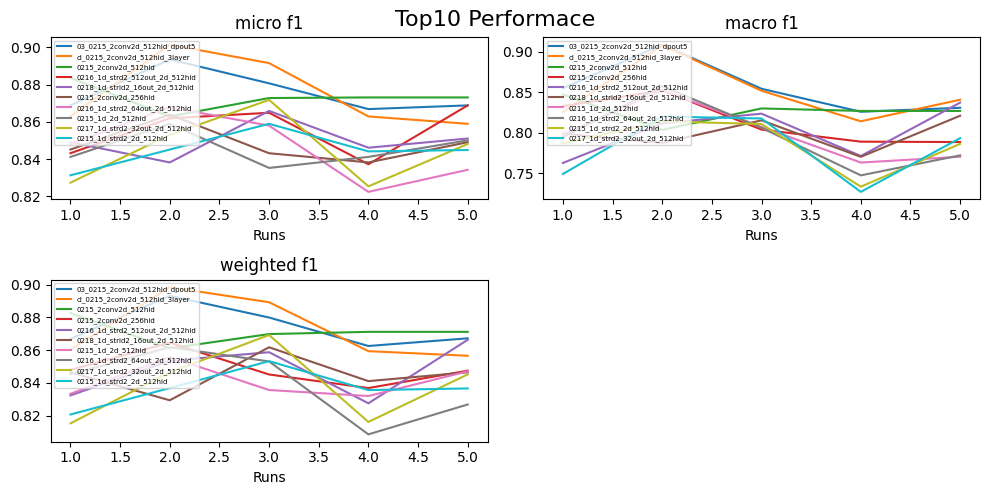

In [18]:
def fill_empty(l, pad=0):
    len_l = len(l)
    if pad == "mean":
        pad = np.array(l).mean()
    for _ in range(logit.MAX_RUNS-len_l):
        l.append(pad)
    
def exclude_log_name(name):
    if 'seizure' in name:
        return True
    return False
    
def exclude_log_data(data):
    d = np.array(data)
    if np.min(d) > 0.1 and np.min(d) < 0.6:
        return True
    return False


def skip(name, data):
    skip = exclude_log_data(data) or exclude_log_name(name)
    return skip

def topk_data(datas, K=5):
    topk = []
    top_mean = dict()
    for i, ms in enumerate(datas):
        for file_name, values in ms.items():
            top_mean[i] = np.array(values).mean()
    
    sorted_data = sorted(top_mean.items(), key=lambda x: x[1], reverse=True)
    for i in range(K):
        id = sorted_data[i][0]
        topk.append(datas[id])
    
    return topk
    

def filter_data(db, topK=5):
    datas = []
    for file_name, v in db.items():
        data = dict()
        data[logit.m1] = v[logit.m1]
        data[logit.m2] = v[logit.m2]
        data[logit.m3] = v[logit.m3]
        if skip(file_name, data[logit.m1]):
            continue
        datas.append({file_name:data})
    
    metrics = defaultdict(list)
    for d in datas:
        for file_name, data in d.items():
            for m_name, v in data.items():
                metrics[m_name].append({file_name:v})
    # print(metrics)
                
    for m_name, data in metrics.items():
        topk = topk_data(data, K=topK)
        for m in topk:
            for _, d in m.items():
                fill_empty(d, pad="mean")
        metrics[m_name] = topk
    return metrics
    
        

def plot_metrics(db, topK=5):
    
    xs = list(range(1, logit.MAX_RUNS+1))
    top_k = filter_data(db,topK)
    
    fig = plt.figure(figsize=(10,5), dpi=100)
    fig.patch.set_facecolor('white')
    
    for i, (m, d) in enumerate(top_k.items()):
        ax = fig.add_subplot(2, 2, i+1)
        legends = []
        yss = []
        for metrics in d:
            for k, v in metrics.items():
                legends.append(k)
                yss.append(v)
                if k == '0215_1d_strd2_2d_512hid':
                    print(v)
        for ys in yss:
            ax.plot(xs, ys)
        ax.legend(legends, fontsize=5,title_fontsize=3,loc='upper left')
        ax.set_title(f'{m}')
        ax.set_xlabel('Runs')
    fig.tight_layout()
    fig.suptitle(f'Top{topK}',fontsize=16)
    # plt.show()
    
plot_metrics(metrics, topK=10)